#  Cells Colonies Detection

## Contents

- [EDA](#EDA)
- [Prepare Dataset for Training using YOLOv8](#prepare-dataset)
- [Train YOLO](#train-yolo)
- [TEST Dataset Validation](#test-dataset)
- [Inference](#Inference)

In [237]:
%load_ext autoreload
%autoreload 2

import json
import csv
import os
from pathlib import Path

from typing import Dict, Any, List, Tuple, Union
import shutil

import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import numpy as np
import pandas as pd
from skmultilearn.model_selection import IterativeStratification

import matplotlib.pyplot as plt
import seaborn as sns

import torch

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(42)

In [176]:
DATA_PATH = "./data"
DATASET_PATH = "./datasets"

## EDA <a class="anchor" id="eda"></a>

In [177]:
# parse annotation data
parsed_data = []
for dirpath, _, file_names in os.walk(DATA_PATH):
    for file_name in file_names:
        if file_name[-4:]=='json':
            file_path = os.path.join(dirpath, file_name)
            with open(file_path, 'r') as file:
                data = json.load(file)
            for file, filedata in data.items():
                filename = filedata['filename']
                for region in filedata['regions']:
                    shape_attr = region['shape_attributes']
                    region_attr = region['region_attributes']
                    parsed_data.append({
                        'filename': filename,
                        'shape_name': shape_attr.get('name'),
                        'x': shape_attr.get('x'),
                        'y': shape_attr.get('y'),
                        'width': shape_attr.get('width'),
                        'height': shape_attr.get('height'),
                        'class_name': region_attr.get('Type')
                    })

# Create a DataFrame from the parsed data
df = pd.DataFrame(parsed_data)
df.sample(5)

,filename,shape_name,x,y,width,height,class_name
1344,чашка 12.jpg,rect,2874,4551,274,183,Dense
65,чашка 3.jpg,rect,1236,679,129,115,Dense
1425,чашка 6.jpg,rect,2361,351,160,152,Diffuse
1506,чашка 6.jpg,rect,323,5796,295,355,Dense
1809,чашка 7.jpg,rect,1450,7334,160,90,Diffuse


In [178]:
#Delete Dublicates
df = df.drop_duplicates()

In [179]:
#Create class dictionary for labels 
class_dict = {'Mixed': 0, 'Diffuse': 1, 'Dense': 2}
df['class_num']= df['class_name']
df['class_num'].replace(class_dict, inplace=True)
df['class_num'].fillna(-1, inplace=True)
df['class_num']=df['class_num'].astype('int8')

In [180]:
#Explore bboxes with None class
df[df['class_num']== -1]

,filename,shape_name,x,y,width,height,class_name,class_num
201,чашка 4.jpg,rect,3713,6017,201,136,None,-1
617,чашка 10.jpg,rect,1587,6687,237,213,None,-1
1305,чашка 12.jpg,rect,4007,2433,167,185,None,-1
1371,чашка 12.jpg,rect,1684,4736,186,143,None,-1
1487,чашка 6.jpg,rect,3547,1249,211,124,None,-1


In [192]:
#Function to visualize images with bboxes
def draw_bboxes(images: List[str], datapath: str, df: pd.DataFrame, figsize: Tuple[int, int] = (15, 5), plot_row: int = 2, plot_col: int = 2):
    plt.figure(figsize=figsize)
    for i, image_file in enumerate(images):
        img_path = os.path.join(datapath, image_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_data = df[df['filename'] == image_file]
        for _, row in image_data.iterrows():
            if row['class_num'] == 0:
                color = (255, 165, 0) # orange for 'Mixed'
            elif row['class_num'] == 1:
                color = (0, 255, 0)  # Green for 'Diffuse'
            elif row['class_num'] == 2:
                color = (0, 0, 255)  # Blue for 'Dense'
            else:
                color = (255, 0, 0)   # red for undefined classes
            cv2.rectangle(image, (row.x, row.y), (row.x + row.width, row.y + row.height), color, 10)
        ax = plt.subplot(plot_row, plot_col, i + 1)
        ax.set_title(image_file, fontsize = 7)
        ax.imshow(image)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

In [185]:
##Visualize random images with bboxes
# NUM_IMAGES = 2
# unique_images = np.random.choice(df['filename'].unique(), NUM_IMAGES, replace=False)
# draw_bboxes(unique_images, datapath=DATA_PATH, df=df, figsize=(10, 18), plot_row=1, plot_col=2)

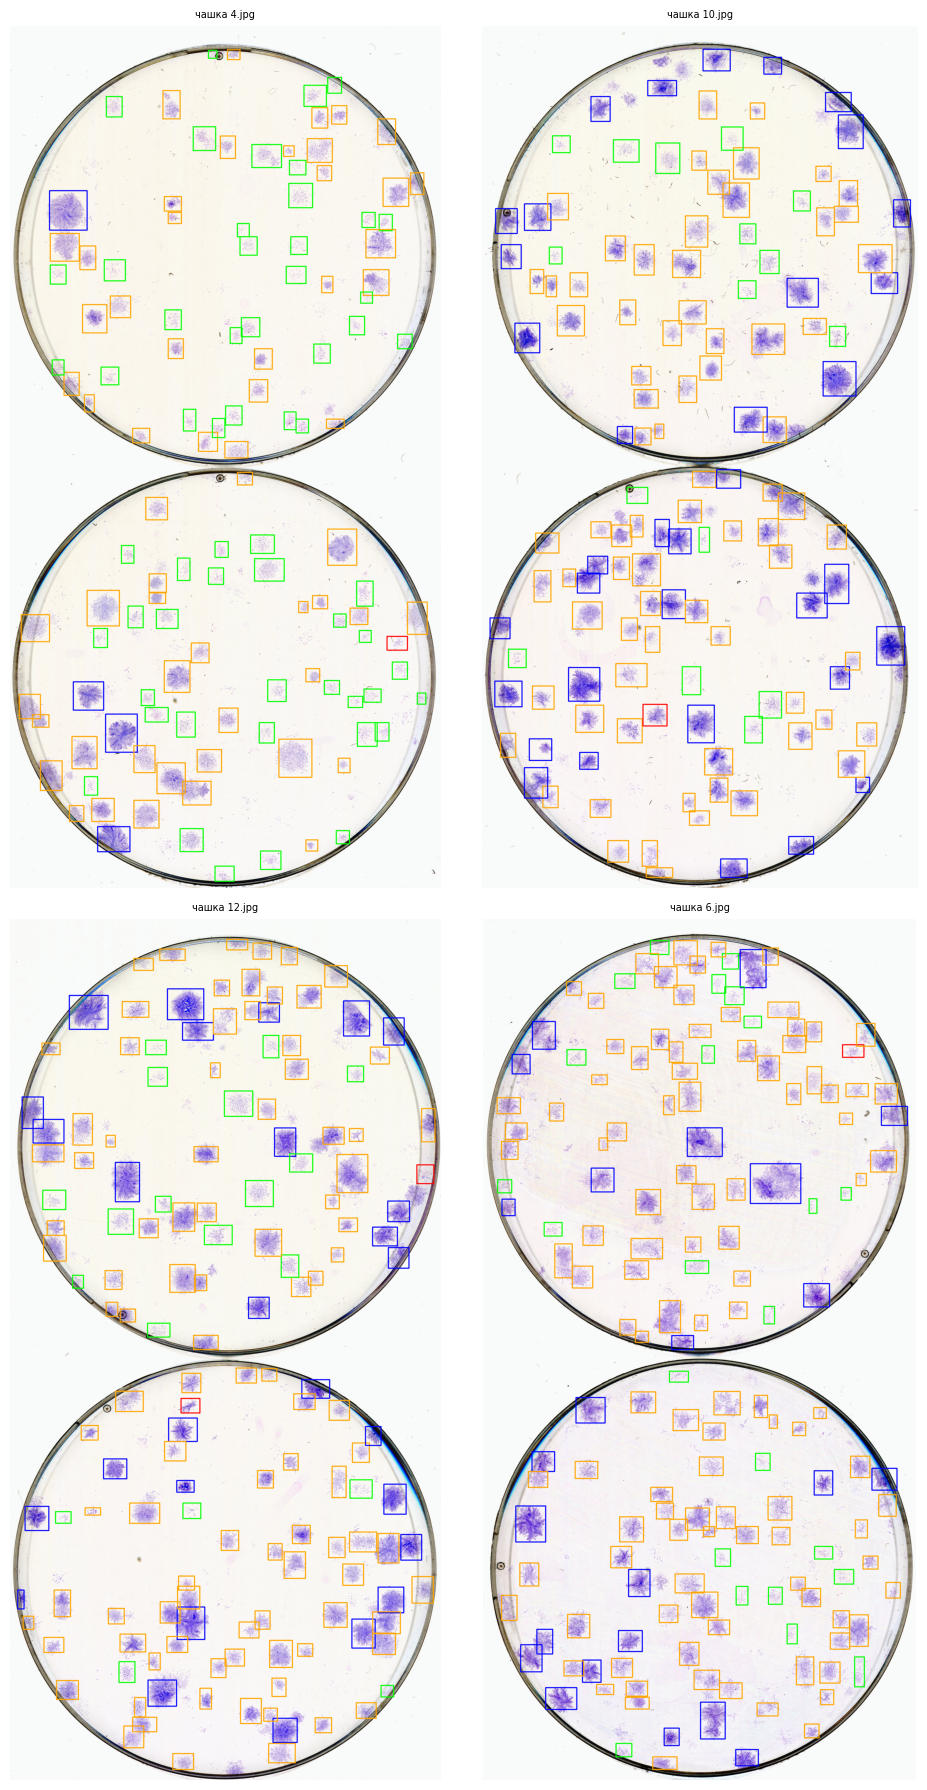

In [193]:
#Visualize images with non classes
unique_images = df[df['class_num']== -1]['filename'].unique()

draw_bboxes(unique_images, datapath=DATA_PATH, df=df, figsize=(10, 18), plot_row=2, plot_col=2)

In [198]:
#Undefined class can be converted to 'Mixed'
df.loc[df['class_num'] == -1, 'class_name'] = 'Mixed'
df.loc[df['class_num'] == -1, 'class_num'] = 0

unique_class_nums = df['class_num'].unique()
print(unique_class_nums)

[1 0 2]


In [199]:
#Add column with image size
df['im_size'] = None
for i, row in df.iterrows():
    img_path = os.path.join(DATA_PATH, row['filename'])
    image = Image.open(img_path)
    im_size = image.size
    df.at[i, 'im_size'] = im_size
df.sample(3)

,filename,shape_name,x,y,width,height,class_name,class_num,im_size
179,чашка 4.jpg,rect,2123,3745,162,188,Diffuse,1,"(4245, 8498)"
782,чашка 8.1.jpg,rect,3233,2759,150,174,Mixed,0,"(4352, 8498)"
1373,чашка 12.jpg,rect,701,5003,167,143,Mixed,0,"(4245, 8498)"


## Check and Clean dataset from incorrect and overlapping bboxes

In [210]:
#Calculate bboxes area
df['bbox_area'] = df['width'] * df['height']
df['bbox_area_rel'] = df.apply(lambda row: row['bbox_area'] / (row['im_size'][0] * row['im_size'][1]), axis=1)
df.sort_values(by='bbox_area', ascending=False).head(3)

,filename,shape_name,x,y,width,height,class_name,class_num,im_size,bbox_area,bbox_area_rel
1469,чашка 6.jpg,rect,2637,2422,498,392,Dense,2,"(4272, 8498)",195216,0.005377
734,чашка 11.jpg,rect,1269,5111,435,346,Mixed,0,"(4432, 8498)",150510,0.003996
133,чашка 4.jpg,rect,389,1623,370,389,Dense,2,"(4245, 8498)",143930,0.003990


<Axes: >

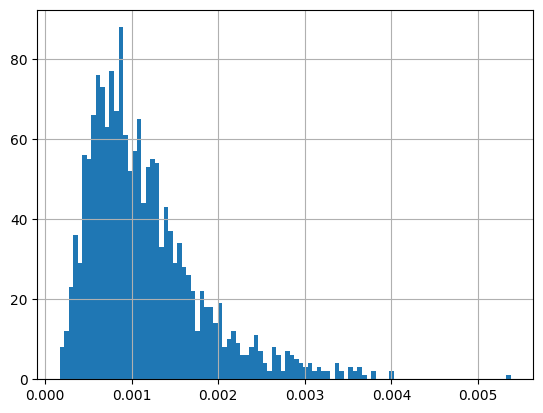

In [209]:
df['bbox_area_rel'].hist(bins=100)

In [244]:
#Check for pairs of bounding boxes with IoU > threshold (not accurate annotation)
def calculate_bbox(row):
    x_min = row['x']
    y_min = row['y']
    x_max = row['x'] + row['width']
    y_max = row['y'] + row['height']
    return x_min, y_min, x_max, y_max


def calculate_iou(box1, box2):
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

THRESHOLD = 0.3

# Add bbox coordinates to the DataFrame
df_iou = df.copy()
df_iou['bbox_coords'] = df_iou.apply(calculate_bbox, axis=1)

# Find pairs of bounding boxes with IoU > Threshold
overlapping_bboxes = []

for i, row1 in df_iou.iterrows():
    for j, row2 in df_iou.iterrows():
        if i < j and row1['filename'] == row2['filename']:
            iou = calculate_iou(row1['bbox_coords'], row2['bbox_coords'])
            if iou > THRESHOLD:
                overlapping_bboxes.append((row1['filename'], i, row1['class_name'], j, row2['class_name'], iou))

# Convert the list of overlapping bboxes to a DataFrame
overlapping_df = pd.DataFrame(overlapping_bboxes, columns=['filename', 'bbox1_index', 'bbox1_class', 'bbox2_index', 'bbox2_class', 'iou'])

overlapping_df

,filename,bbox1_index,bbox1_class,bbox2_index,bbox2_class,iou


In [212]:
#Export filtered dataframe
df.to_csv(os.path.join(DATA_PATH, 'dataset.csv'), index=False)

## Analysis of classes and bboxes

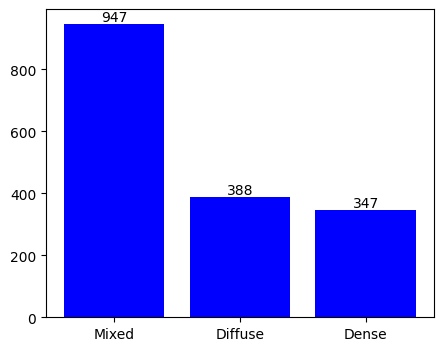

In [213]:
#Class Balance analysis

plt.figure(figsize=(5, 4))

class_count = df['class_name'].value_counts()
bars = plt.bar(class_count.index, class_count.values, color='blue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')
plt.show()

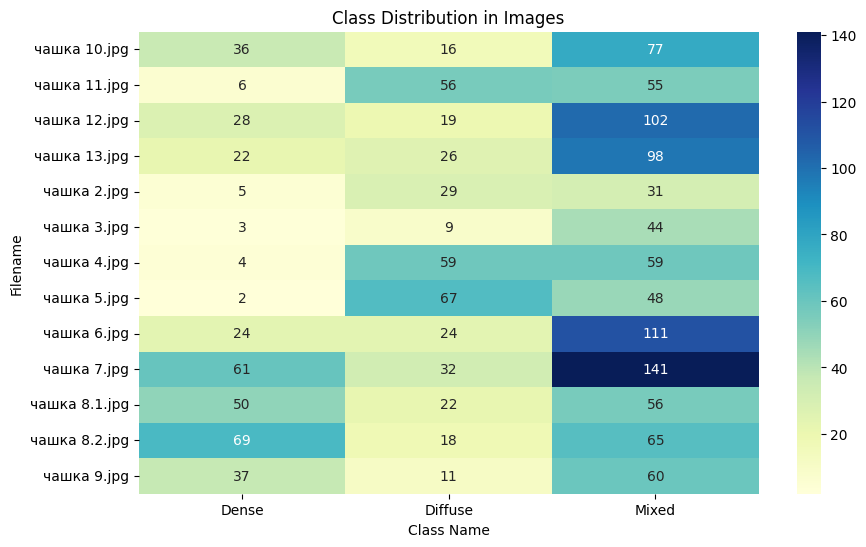

In [214]:
# Counting the number of occurrences of each class in each image
class_distribution = df.groupby('filename')['class_name'].value_counts().unstack(fill_value=0)

# Plotting the distribution using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(class_distribution, annot=True, cmap="YlGnBu", fmt='d')
plt.title('Class Distribution in Images')
plt.xlabel('Class Name')
plt.ylabel('Filename')
plt.show()

## Комментарии по выбору модели <a class="anchor" id="comments on model selection"></a>

## Prepare Dataset for YoloV8 <a class="anchor" id="prepare-dataset"></a>

### Creat txt files with YOLO annotation

In [223]:
def convert_bbox_to_yolo(x, y, width, height, img_width, img_height):
    """
    Convert bounding box format from top-left coordinates to YOLO format.
    """
    x_center = (x + width / 2) / img_width
    y_center = (y + height / 2) / img_height
    width = width / img_width
    height = height / img_height
    return x_center, y_center, width, height

annotations = {}

for index, row in df.iterrows():
    filename = row['filename'].strip()
    class_num = int(row['class_num'])
    x, y, width, height = row['x'], row['y'], row['width'], row['height']
    # Process 'im_size' to extract image width and height
    img_size_str = row['im_size']
    img_width, img_height = int(img_size_str[0]), int(img_size_str[1])
    # Convert to YOLO format
    x_center, y_center, width, height = convert_bbox_to_yolo(x, y, width, height, img_width, img_height)
    # Prepare annotation line
    annotation_line = f"{class_num} {x_center} {y_center} {width} {height}\n"
    # Add annotation line to corresponding file
    if filename not in annotations:
        annotations[filename] = []
    annotations[filename].append(annotation_line)


for filename, lines in annotations.items():
    base_filename = os.path.splitext(filename)[0]
    output_file = os.path.join(DATA_PATH, base_filename + '.txt')
    with open(output_file, 'w') as f:
        f.writelines(lines)

### Creat Train, Valid and Test folders for YOLO training using Stratified Test Split

In [224]:
#function for onehot encoding for classes
def onehot_classes(df_class_list: pd.DataFrame, class_dict: dict) -> pd.DataFrame:
    df_one_hot = pd.DataFrame(np.zeros((len(df_class_list), len(class_dict))), columns=[str(i) for i in range(len(class_dict))])
    df_one_hot.astype('int8')
    df_one_hot.index = df_class_list.index

    for index, row in df_class_list.iterrows():
        for class_label in row['class_num']:
            class_label_str = str(class_label)
            df_one_hot.at[index, class_label_str] += 1
    df_class_list = pd.concat([df_class_list, df_one_hot], axis=1)
    return df_class_list

In [225]:
# Create list of classes for each image
df_class_list = df.groupby('filename')['class_num'].apply(list).reset_index()

# Make one hot encoding for classes for further split
df_class_list = onehot_classes(df_class_list, class_dict)

In [226]:
df_class_list

,filename,class_num,0,1,2
0,чашка 10.jpg,"[2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, ...",77.0,16.0,36.0
1,чашка 11.jpg,"[2, 0, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",55.0,56.0,6.0
2,чашка 12.jpg,"[2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, ...",102.0,19.0,28.0
3,чашка 13.jpg,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, ...",98.0,26.0,22.0
4,чашка 2.jpg,"[1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, ...",31.0,29.0,5.0
5,чашка 3.jpg,"[2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 1, ...",44.0,9.0,3.0
6,чашка 4.jpg,"[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, ...",59.0,59.0,4.0
7,чашка 5.jpg,"[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 1, ...",48.0,67.0,2.0
8,чашка 6.jpg,"[0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 0, 0, ...",111.0,24.0,24.0
9,чашка 7.jpg,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, ...",141.0,32.0,61.0


In [233]:
def stratify_shuffle_split_subsets(
    annotation: pd.DataFrame,
    train_fraction: float = 0.8,
) -> Tuple[np.ndarray, np.ndarray]:

    x_columns = ['filename']
    y_columns = list(annotation.select_dtypes('float').columns)

    all_x = annotation[x_columns].to_numpy()
    all_y = annotation[y_columns].to_numpy()

    train_indexes, valid_indexes = _split(all_x, all_y, distribution=[1 - train_fraction, train_fraction])
    x_train, x_valid = all_x[train_indexes], all_x[valid_indexes]

    x_train = [i[0] for i in x_train]
    x_valid = [i[0] for i in x_valid]

    return x_train, x_valid


def _split(
    xs: np.array,
    ys: np.array,
    distribution: Union[None, List[float]] = None,
) -> Tuple[np.array, np.array]:
    stratifier = IterativeStratification(n_splits=2, sample_distribution_per_fold=distribution)
    first_indexes, second_indexes = next(stratifier.split(X=xs, y=ys))

    return first_indexes, second_indexes

In [234]:
TRAIN_FRACTION = 0.8
DATASET_MODES = ['train', 'valid']

x_train, x_valid = stratify_shuffle_split_subsets(df_class_list, TRAIN_FRACTION)
subsets = x_train, x_valid
print(len(x_train), len(x_valid))

subsets_dict = {}
for name, subset in zip(DATASET_MODES, subsets):
    subsets_dict[name] = subset

10 3


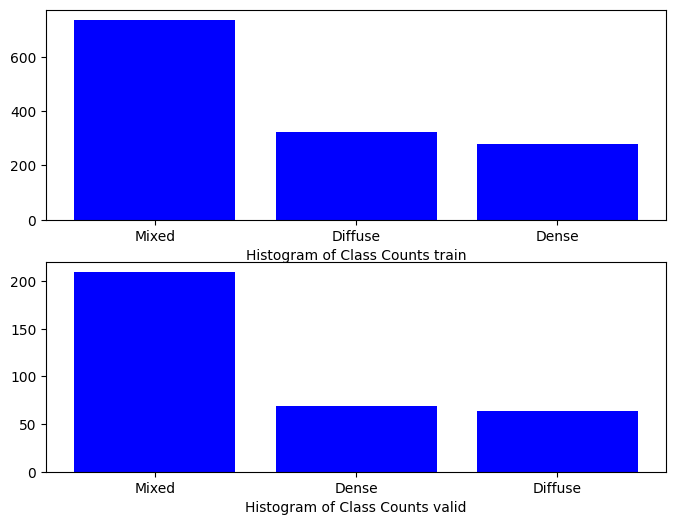

In [236]:
#Class Balance after split
plt.figure(figsize=(8, 6))

for num, subset in enumerate((x_train, x_valid)):
    ax = plt.subplot(2, 1, num + 1)
    class_count = df[df['filename'].isin(subset)]['class_name'].value_counts()
    ax.bar(class_count.index, class_count.values, color='blue')
    ax.set_xlabel('Class ID')
    ax.set_xlabel('Count')
    ax.set_xlabel(f'Histogram of Class Counts {DATASET_MODES[num]}')
plt.show()

In [241]:
#Copy files and annotations accourding to YOLO data structure
def copy_to_folders(
    dest_folder: str,
    source_folder: str,
    dataset_modes: list,
    subsets_dict: dict,
) -> None:
    dest_folder = Path(dest_folder)
    mode_source_folder = Path(source_folder)

    for mode in dataset_modes:
        dest_path_image = dest_folder / 'images' / mode
        dest_path_labels = dest_folder / 'labels' / mode

        dest_path_image.mkdir(parents=True, exist_ok=True)
        dest_path_labels.mkdir(parents=True, exist_ok=True)

        for image in subsets_dict[mode]:
            initial_path_image = mode_source_folder / image
            destination_path_image = dest_path_image / image
            shutil.copy(initial_path_image, destination_path_image)

            initial_path_labels = mode_source_folder / f"{image[:-3]}txt"
            destination_path_labels = dest_path_labels / f"{image[:-3]}txt"
            shutil.copy(initial_path_labels, destination_path_labels)


copy_to_folders(DATASET_PATH, DATA_PATH, DATASET_MODES, subsets_dict)

In [242]:
#Check number of files copied is correct
for mode in DATASET_MODES:
    mode = str(mode)
    folder_path = Path('./datasets/images') / mode
    file_count = len([file for file in folder_path.iterdir() if file.is_file()])
    print(file_count)

10
3


## Create yaml file

In [243]:
# import yaml

# # YAML content as specified
# yaml_content = {
#     'path': DATASET_PATH,
#     'train': 'images/train',
#     'val': 'images/valid',
#     'nc': 3,
# }

# # Path for the YAML file
# yaml_file_path = Path(DATASET_PATH) / 'dataset_cells.yaml'

# # Write the YAML file
# with open(yaml_file_path, 'w') as file:
#     yaml.dump(yaml_content, file)

# yaml_file_path  # Return the path of the created YAML file

PosixPath('datasets/dataset_cells.yaml')

## Train YOLOv8 <a class="anchor" id="train-yolo"></a>

In [ ]:
model = YOLO("yolov8s.pt")

In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data="./datasets/dataset_plate.yaml" epochs=60 imgsz=320 batch=16 device=0 plots=True max_det=7 fliplr=0 close_mosaic=0

### Result of Training

In [ ]:
#Visualize training results
TRAIN_RESULTS_PATH = "./runs/detect/train"

tpaths2=[]
for dirname, _, filenames in os.walk(TRAIN_RESULTS_PATH):
    for filename in filenames:
        if filename[-4:]=='.png':
            tpaths2+=[(os.path.join(dirname, filename))]
tpaths2=sorted(tpaths2)

for path in tpaths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(10,6))
    plt.imshow(image)
    plt.show()

In [ ]:
#Visualize batch images
tpaths2=[]
for dirname, _, filenames in os.walk(TRAIN_RESULTS_PATH):
    for filename in filenames:
        if filename[-4:]=='.jpg' and "batch1" in filename:
            tpaths2+=[(os.path.join(dirname, filename))]
tpaths2=sorted(tpaths2)
print(tpaths2[0])

for path in tpaths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.title(path.split('\\')[-1])
    plt.show()

## TEST Dataset Validation <a class="anchor" id="test-dataset"></a>

In [ ]:
!yolo task=detect mode=val model="./runs/detect/train/weights/best.pt" data="./datasets/dataset_plate.yaml" save_json=True max_det=7 plots=True split=test

In [ ]:
#Visualize TEST results
VAL_RESULTS_PATH = "./runs/detect/val"

tpaths2=[]
for dirname, _, filenames in os.walk(VAL_RESULTS_PATH):
    for filename in filenames:
        if filename[-4:]=='.png':
            tpaths2+=[(os.path.join(dirname, filename))]

for path in tpaths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(10,6))
    plt.imshow(image)
    plt.show()

In [ ]:
#Visualize TEST prediction batch images
tpaths2=[]
for dirname, _, filenames in os.walk(VAL_RESULTS_PATH):
    for filename in filenames:
        if filename[-4:]=='.jpg' and "batch1" in filename:
            tpaths2+=[(os.path.join(dirname, filename))]
tpaths2=sorted(tpaths2)

for path in tpaths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.title(path.split('\\')[-1])
    plt.show()

## Inference <a class="anchor" id="inference"></a>

In [ ]:
BEST_MODEL = "./runs/detect/train/weights/best.pt"
SAVE_IMAGE = './inference_results/result.jpg'
# Load a model
model = YOLO(BEST_MODEL)  # pretrained YOLOv8n model

# Run batched inference on a list of images
images_paths = os.path.join(DATA_PATH, 'test', x_test[0])

results = model([images_paths])  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    result.show()  # display to screen
    result.save(filename=SAVE_IMAGE)  # save to disk

results[0].boxes.data

In [ ]:
image = cv2.imread(SAVE_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()